## Image Retrieval 과제

In [1]:
# Import libraries
import cv2
import os
import numpy as np
import numpy.linalg as LA
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import resize
from skimage.feature import hog
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms

import warnings
warnings.filterwarnings('ignore')

실습시간에는 VGG19와 ResNet을 Feature Extractor로 사용했는데, 이번 과제에서는 DenseNet을 Feature Extractor로 사용해봅니다.

추가로 data는 저번에 Image Retrieval을 위해 사용했던 data를 그대로 사용합니다.

In [2]:
class DenseNet(nn.Module):
    def __init__(self):
        super(DenseNet, self).__init__()
        self.densenet = torchvision.models.densenet121(pretrained = True) # DensetNet model is imported
        
        # add the codes
        self.densenet = nn.Sequential(* list(self.densenet.children())[:-1])
        
    def forward(self, x):
        out = self.densenet(x)
        
        # Hint : https://pytorch.org/docs/stable/_modules/torchvision/models/densenet.html#densenet121
        out = F.relu(out, inplace=True)
        out = F.avg_pool2d(out, kernel_size=7, stride=7)
        
        return out

# Set our model with pre-trained model 
densenet = DenseNet().cuda()
densenet.eval()

DenseNet(
  (densenet): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, a

In [3]:
# Extract ConvNet Features (VGG19, ResNet)
def extract_deep_features(path, feature_extractor, feature_size):
    start_time = time.time()
    
    list_imgs_names = os.listdir(path) #list_imgs_names
    N = len(list_imgs_names)
    feature_all = np.zeros((N, feature_size)) # create an array to store features
    image_all = [] # define empy array to store image names
    
    transform = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
    # extract features 
    for index, img_name in enumerate(list_imgs_names):
        img_path = os.path.join(path, img_name)
        
        # Image Read & Resize
        image_np = Image.open(img_path) # Read the images
        image_np = np.array(image_np)
        image_np = resize(image_np, (224, 224), mode='constant') # Resize the images
        image_np = torch.from_numpy(image_np).permute(2, 0, 1).float()
        image_np = transform(image_np)
        image_np = Variable(image_np.unsqueeze(0))   #bs, c, h, w
        image_np = image_np.cuda()
        
        # Extract Feature
        feature = feature_extractor(image_np)
        feature = feature.squeeze().cpu().data.numpy()
        feature = feature.reshape((1, feature_size)) # Feature Flatten
        feature = feature / LA.norm(feature) # Feature Normalization
        feature_all[index] = feature
        image_all.append(img_name)

    time_elapsed = time.time() - start_time

    print('Feature extraction complete in {:.02f}s'.format(time_elapsed % 60))

    return feature_all, image_all

In [4]:
def test_deep_feature(feature_extractor, feature_size):
    # Extract features from the dataset
    print('Extract features from data')
    path = './data'
    feats, image_list = extract_deep_features(path, feature_extractor, feature_size=feature_size)

    # test image path
    print('Extract features from query image')
    test = './test'
    feat_single, image = extract_deep_features(test, feature_extractor, feature_size=feature_size)
    
    # Calculate the scores
    scores  = np.dot(feat_single, feats.T)
    sort_ind = np.argsort(scores)[0][::-1] # sort the scores
    scores = scores[0, sort_ind]

    # Show the results
    maxres = 10
    imlist = [image_list[index] for i, index in enumerate(sort_ind[0:maxres])]
    print ("top %d images in order are: " %maxres, imlist)

    fig=plt.figure(figsize=(16, 10))
    for i in range(len(imlist)):
        sample = imlist[i]
        img = mpimg.imread('./data' + '/' + sample)
        ax = fig.add_subplot(2, 5, i+1)
        ax.autoscale()
        plt.tight_layout()
        plt.imshow(img, interpolation='nearest')
        ax.set_title('{:.3f}%'.format(scores[i]))
        ax.axis('off')
    plt.show()

Extract features from data
Feature extraction complete in 10.01s
Extract features from query image
Feature extraction complete in 0.17s
top 10 images in order are:  ['AmidaBuddha.jpg', 'AmidaBuddha03.jpg', 'AmidaBuddha01.jpg', 'AmidaBuddha07.jpg', 'AmidaBuddha06.jpg', 'AmidaBuddha05.jpg', 'AmidaBuddha04.jpg', 'AmidaBuddha08.jpg', 'AmidaBuddha02.jpg', 'CommandoMemorial10.jpg']


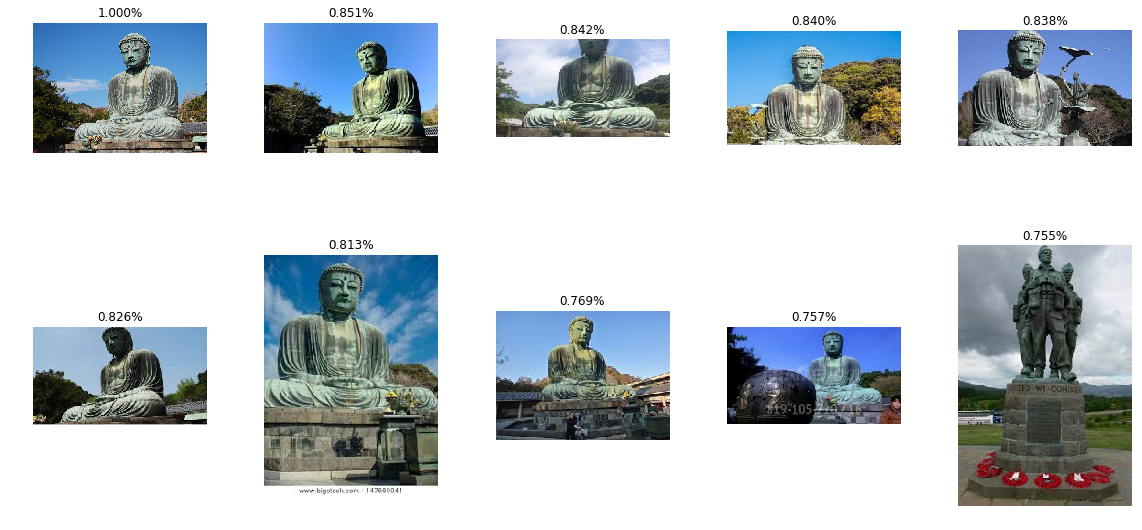

In [5]:
# DenseNet Image Retrieval Results
test_deep_feature(densenet, feature_size=1024)